# COVID-19 Report Generation using Telegram Bot 

- This bot provides you statistics on the COVID-19 Virus Count. It generates a country wise report, based on the country of your choice. 

- It also supports a statewise selection for the countries of USA, China and Australia.

- The generated report contains statistics and graphical representations which provides a quick analysis of COVID-19 status of your state/country.

- The data is updated daily from the [John Hopkins COVID-19 repository](https://github.com/CSSEGISandData/COVID-19).

In [1]:
import pandas as pd
import datetime
from datetime import date
import matplotlib.pyplot as plt
import re
import numpy as np
import kaggle
import wikipedia
import numpy as np

In [2]:
current = date.today() 
today = current - datetime.timedelta(days=1) #obtaining the date for generating the report

In [3]:
today = today.strftime("%m/%d/%Y") #type casting the date to a string

In [4]:
corona = pd.read_csv('covid_19_data.csv', index_col=0)  #reading the dataset
corona['Country/Region'] = corona['Country/Region'].str.replace('US','USA') #replacing the name US with USA  

In [5]:
today = corona[corona['ObservationDate'] == today] #retrieving a subset of the dataset to this particular day

In [6]:
countries = list(set(list(today['Country/Region'].str.lower()))) #obtaining a list of countries

In [7]:
pd.options.mode.chained_assignment = None #for ignoring the set with copy warning

## Generate Report Function

- This function takes in 3 parameters message, column type and the date. The column type parameter is used to identify whether it's a state or a country.
- It returns the calculated statistics and saves a pdf file which will contain the report for the country or state.
- The generated pdf report contains: 
    - Numerical statistics 
    - Line Graph representing the growth of Confirmed cases.
    - Bar Graph representing the growth of Daily Cases.
    - A Pie Graph containing the status of the Confimred Cases.

In [8]:
def generate_report(msg, col_type, today):
    value = today[today[col_type].str.lower().str.contains(msg, na=False)]
    value['Active'] = value['Confirmed'] - (value['Recovered'] + value['Deaths'])
    recovered_percent = ((value['Recovered'].sum())/ (value['Confirmed'].sum() + value['Deaths'].sum()))*100
    
    pie_df = pd.DataFrame()
    pie_df.insert(0,'Metrics',value = ['Active','Deaths','Recovered'], allow_duplicates=False)
    pie_df.insert(1,'COVID 19 Metrics',value = [value['Active'].sum(),value['Deaths'].sum(),value['Recovered'].sum()], allow_duplicates=False)
    pie_df = pie_df.set_index('Metrics')
    

    temp_df = corona[corona[col_type].str.lower().str.contains(msg, na=False)]
    test = pd.DataFrame(temp_df.groupby(['ObservationDate'])['Confirmed'].sum()).reset_index()
    recovered = pd.DataFrame(temp_df.groupby(['ObservationDate'])['Recovered'].sum()).reset_index()
    deaths = pd.DataFrame(temp_df.groupby(['ObservationDate'])['Deaths'].sum()).reset_index()
    
    test['Active_Cases'] = test['Confirmed'] - (recovered['Recovered'] + deaths['Deaths'])
    test['Daily_Cases'] = test['Confirmed'].diff()
    
    daily = pd.DataFrame()
    daily['ObservationDate'] = test['ObservationDate'].copy()
    daily['Daily_Cases'] = test['Daily_Cases'].copy()
    daily = daily[daily['Daily_Cases']>0]
    
    test['pct_change'] = test['Confirmed'].pct_change()
    growth_percent = test['pct_change'].iloc[-1]*100
    change = growth_percent - test['pct_change'].iloc[-2]*100
    
    fig = plt.figure(figsize=(25,10))
    ax1 = fig.add_subplot(222)
    ax2 = fig.add_subplot(223)
    ax3 = fig.add_subplot(224)
    
    textstr = "Last Updated: "+str(value.iloc[0]['Last Update'])+ "\n" + "Confirmed: " +str(value['Confirmed'].sum())+ "\n" + "Deaths: "+str(value['Deaths'].sum())+ "\n" + "Recovered: "+str(value['Recovered'].sum())+"\nPercentage Recovered: "+str(round(recovered_percent,2))+"%"+"\nDaily Growth Percentage of Spread: "+str(round(growth_percent,2))+"% ("+str(round(change,2))+"%)"+"\nActive Cases: "+str(value['Active'].sum())
    heading =  msg.upper() + " COVID 19 Report"
    
    plt.text(0.15, 0.65, textstr, fontsize=18, transform=plt.gcf().transFigure, bbox=dict(facecolor='white', alpha=0.5))
    plt.text(0.45, 0.93, heading,  transform=plt.gcf().transFigure, fontsize = 28)
    
    ax1 = test.plot(x="ObservationDate", y="Active_Cases",
                    kind="line", linestyle="-", color="orange",
                    ax=ax1
                    ) #Adds a line graph
    ax2 = daily.plot(x="ObservationDate", y="Daily_Cases",
                    kind="bar", linestyle="-",color="orange",
                    ax=ax2
                    ) #Adds a bar graph
    ax3 = pie_df.plot(y="COVID 19 Metrics",
                    kind="pie",ax=ax3
                    ) #Adds a pie graph
    
    
    dates = list(daily['ObservationDate'])
    date_index = np.arange(0,len(dates),len(dates)/5)
    formatted_dates = []
    for i in date_index:
        formatted_dates.append(dates[int(i)])
    ax2.locator_params(nbins=5,axis='x')
    ax2.set_xticklabels(formatted_dates, rotation=30)
    ax2.set_title('COVID_19 Daily New Cases')
    ax2.tick_params(axis=u'both', which=u'both',length=0)
    for spine in ax2.spines.values():
        spine.set_visible(False)
    
    ax1.set_title('COVID_19 Active Cases')
    ax1.tick_params(axis=u'both', which=u'both',length=0)
    for spine in ax1.spines.values():
        spine.set_visible(False)
    
    ax3.set_title(msg.upper()+ ' COVID_19 Confirmed Cases Split',y=-0.03)
    ax3.axis('off')
    
    fig.savefig("output.pdf") #saves the file to a jpg
    return value,recovered_percent,growth_percent,change

## Creating the Bot and passing the values to the Bot

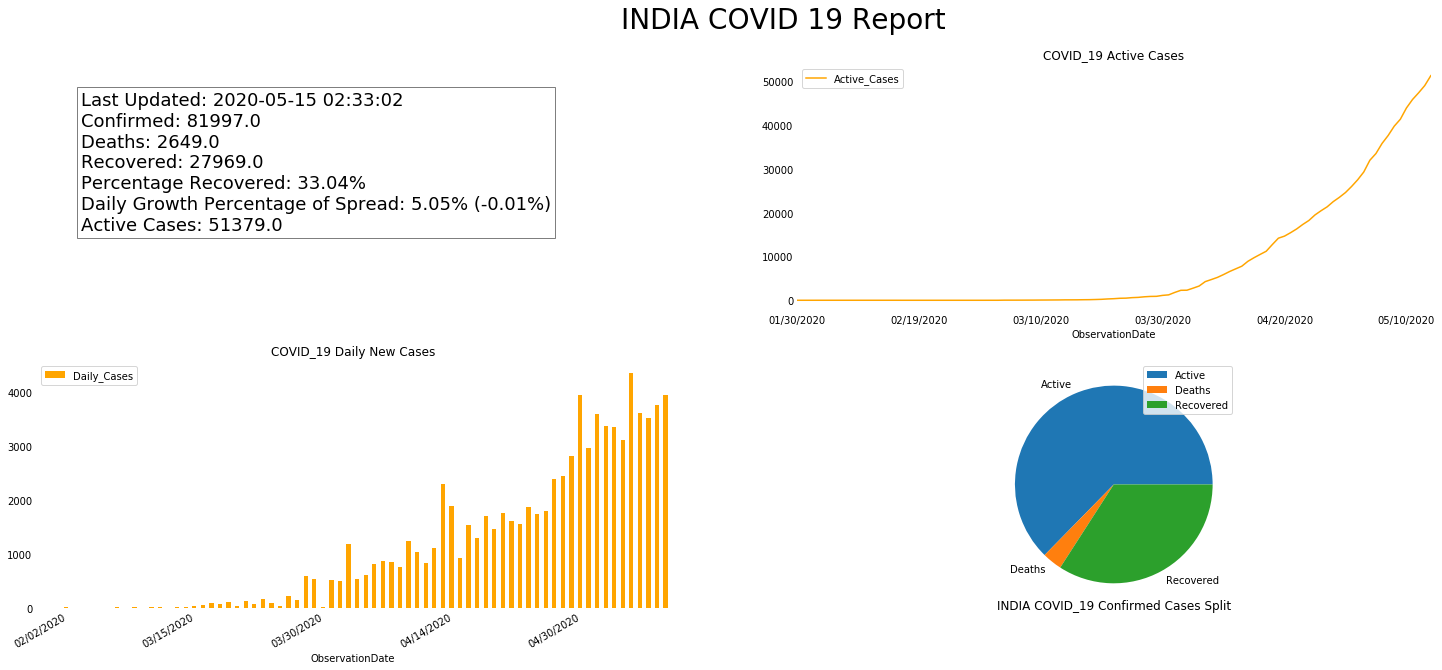

In [9]:
import telebot

from telebot import apihelper

token = '' #Your BOT token
bot = telebot.TeleBot(token)

@bot.message_handler(commands=['start','help'])
def start_message(message):
    bot.send_message(message.chat.id, 'This bot provides you statistics on the COVID-19 virus count. Enter the name of the country, to view the result. Users in the US can now see Province/State wise statistic on the bot. All you have to do is enter the name of the state. Stay strong! Stay healthy! 🖖🏾')
    
@bot.message_handler(content_types=['text'])
def send_text(message):
    try:
        msg = message.text.lower()
        if [x for x in countries if re.search(msg, x)]:
            col_type = 'Country/Region'
            value,recovered,growth,change = generate_report(msg, 'Country/Region',today)
        else:
            col_type = 'Province/State'
            value,recovered,growth,change = generate_report(msg, 'Province/State',today)
        
        #bot.send_message(message.chat.id, "Link To Wikipedia Article:\n"+"https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_"+str(value.iloc[0][col_type]))
        bot.send_message(message.chat.id, "Last Updated: *"+str(value.iloc[0]['Last Update'])+ "\n" + "*Confirmed: *" +str(value['Confirmed'].sum())+ "\n" + "*Deaths: *"+str(value['Deaths'].sum())+ "\n" + "*Recovered: *"+str(value['Recovered'].sum())+"*\nPercentage Recovered: *"+str(round(recovered,2))+"*%*"+"*\nDaily Growth Percentage of Spread: *"+str(round(growth,2))+"*% (*"+str(round(change,2))+"*%)"+"\nActive Cases: *"+str(value['Active'].sum())+"*", parse_mode= 'Markdown')
        bot.send_document(message.chat.id, data = open('output.pdf', 'rb')) #returns the pdf report to the user
        name = message.from_user.first_name
        
    except IndexError:
        
        bot.send_message(message.chat.id, "Statistics for the entered location is unavailable :(") #If the state or Country is unavailable
        
bot.polling()            